In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Đang xử lý 10 ảnh...
------------------------------
KẾT QUẢ ĐO LƯỜNG TỐC ĐỘ:
Thời gian trung bình/ảnh: 0.0662 giây
Tốc độ xử lý tương đương: 15.1 FPS
------------------------------


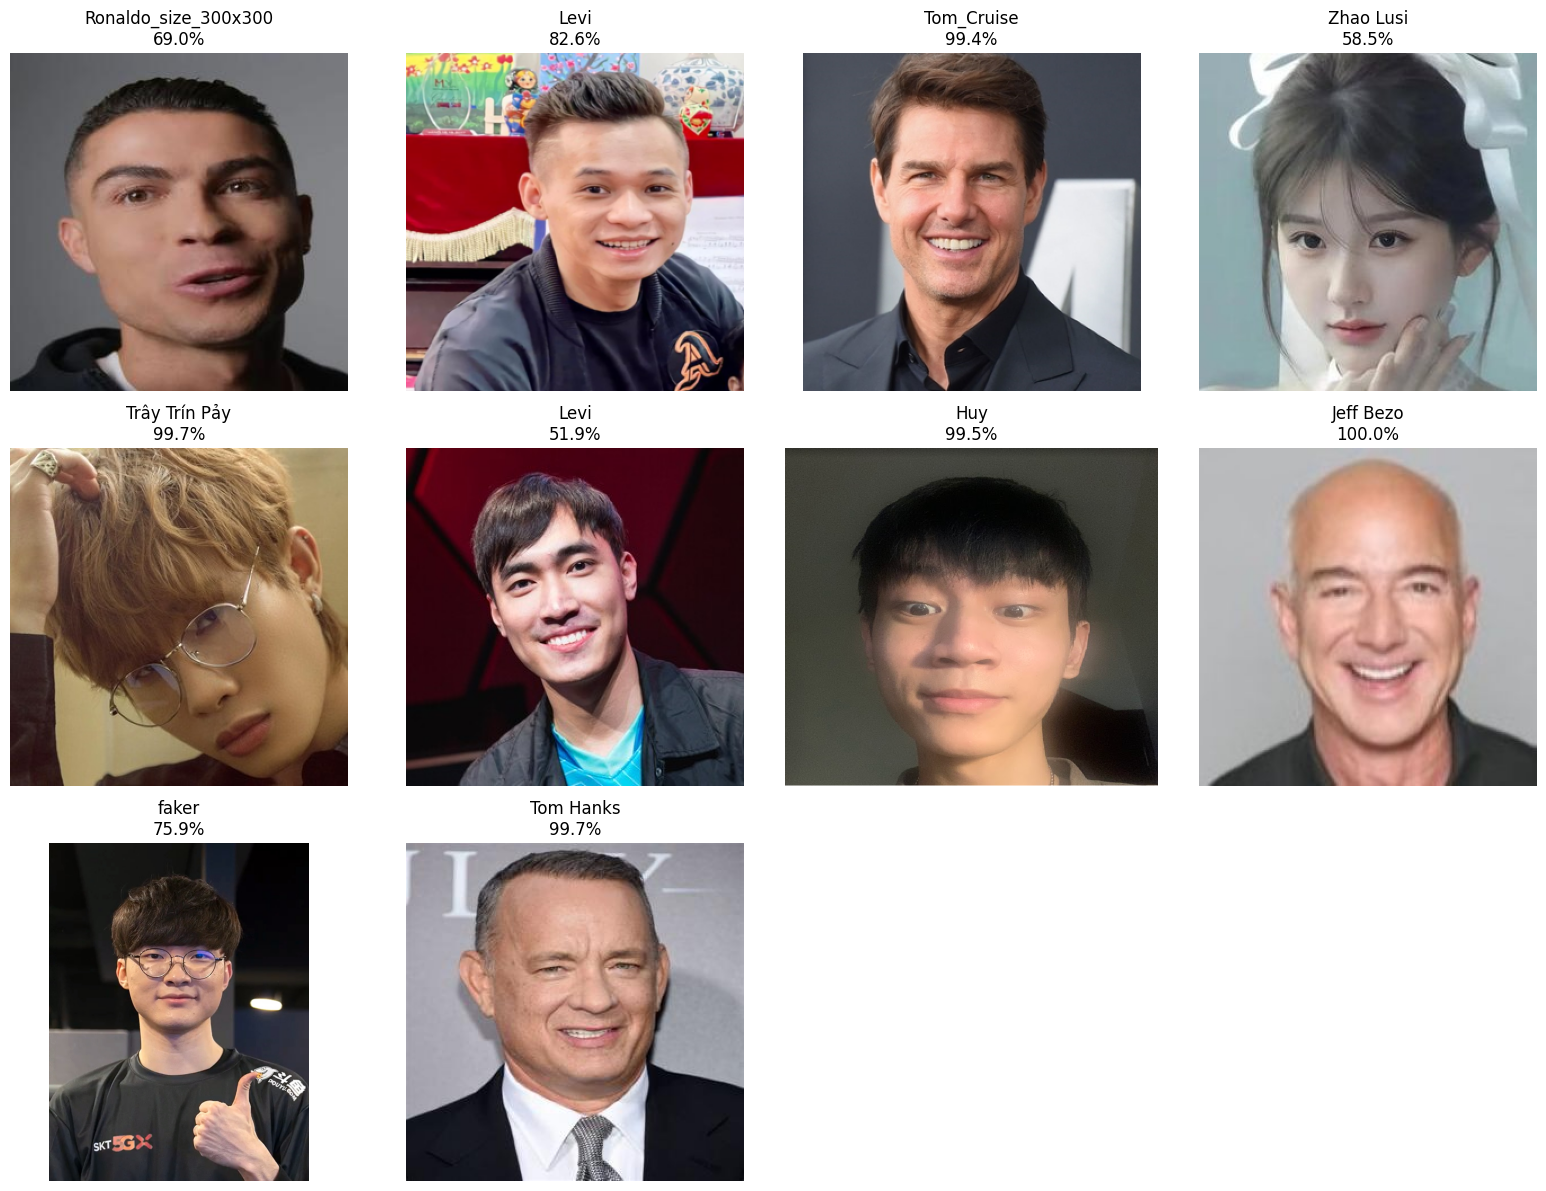

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import time # Thư viện đo thời gian

# 1. Cấu hình thiết bị
DEVICE = torch.device("cpu")
MODEL_PATH = '/content/drive/MyDrive/Hoc_sau/face_recognition_squeezenet_v2.pth'
IMG_SIZE = 227

# Danh sách 30 đối tượng (Giữ nguyên thứ tự nhãn khi Train)
CLASS_NAMES = [
    'Brad Pitt_300x300', 'Conor McGregor', 'David Beckham', 'Erling Haaland',
    'Huy', 'Jeff Bezo', 'Jeffray', 'Joji', 'Khabib', 'Leonardo DiCaprio', 'Levi',
    'Messi', 'Mixigaming', 'Ộ ii', 'Park Hang-seo', 'Robert_Downey_Junior',
    'Ronaldo_size_300x300', 'SonTungMTP', 'Taylor_Swift', 'Tobey_Maguire',
    'Tom Hanks', 'Tom_Cruise', 'Trây Trín Pảy', 'Will_Smith 300x300', 'Zhao Lusi',
    'antony', 'charles_leclerc', 'faker', 'thayongnoi', 'đại tướng Võ Nguyên Giáp 300x300'
]

# 2. Định nghĩa bộ tiền xử lý ảnh (Phải khớp hoàn toàn với lúc Train)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Hàm dựng mô hình và nạp trọng số
def load_trained_model(path, num_classes):
    # Dùng kiến trúc SqueezeNet 1.1
    model = models.squeezenet1_1(weights=None)
    # Thay đổi lớp Classifier để phù hợp với 30 lớp đầu ra
    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))

    # Nạp tham số và ép sang CPU nếu cần (Dùng cho Pi 5)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    return model

# 4. Hàm dự đoán hàng loạt và đo tốc độ
def predict_and_benchmark(folder_path, model):
    if not os.path.exists(folder_path):
        print(f"Lỗi: Thư mục {folder_path} không tồn tại!")
        return

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_time = 0
    results = []

    print(f"Đang xử lý {len(files)} ảnh...")

    for file_name in files:
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path).convert('RGB')

        # Tiền xử lý
        img_tensor = val_transforms(img).unsqueeze(0).to(DEVICE)

        # Bắt đầu đo thời gian Inference
        start_t = time.time()
        with torch.no_grad():
            output = model(img_tensor)
            # Tính toán xác suất bằng Softmax
            prob = torch.nn.functional.softmax(output, dim=1)
            conf, pred = torch.max(prob, 1)
        end_t = time.time()

        # Tích lũy thời gian xử lý (đơn vị: giây)
        total_time += (end_t - start_t)

        results.append({
            'name': CLASS_NAMES[pred.item()],
            'conf': conf.item() * 100,
            'img': img
        })

    # Tính toán các chỉ số cho báo cáo
    if len(files) > 0:
        avg_time = total_time / len(files)
        fps = 1 / avg_time
        print("-" * 30)
        print(f"KẾT QUẢ ĐO LƯỜNG TỐC ĐỘ:")
        print(f"Thời gian trung bình/ảnh: {avg_time:.4f} giây")
        print(f"Tốc độ xử lý tương đương: {fps:.1f} FPS")
        print("-" * 30)

    # Hiển thị kết quả trực quan
    plt.figure(figsize=(16, 12))
    for i, res in enumerate(results):
        plt.subplot((len(results)-1)//4 + 1, 4, i + 1)
        plt.imshow(res['img'])
        plt.title(f"{res['name']}\n{res['conf']:.1f}%")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- THỰC THI ---
my_model = load_trained_model(MODEL_PATH, len(CLASS_NAMES))
predict_and_benchmark('/content/test_images', my_model)